In [1]:
%pip install -q pandas numpy scipy statsmodels matplotlib jinja2


Note: you may need to restart the kernel to use updated packages.


In [2]:
#Imports & setup
import numpy as np, pandas as pd
from pathlib import Path
from datetime import datetime
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7.5, 4.5)
plt.rcParams["axes.grid"] = True


C:\Users\abhij\anaconda3\envs\flask\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
#Point to your CSV & load
CSV_IN = "cookie_cats.csv"  # change if different

raw = pd.read_csv(CSV_IN)
raw.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
#Map to A/B + pick metrics
df = pd.DataFrame({
    "user_id": raw["userid"],
    "variant": raw["version"].map({"gate_30": "A", "gate_40": "B"}),
    "conversion": raw["retention_7"].astype(int),
    "revenue": raw["sum_gamerounds"].astype(float)
}).dropna(subset=["variant","conversion","revenue"])

df.head(), df.variant.value_counts()


(   user_id variant  conversion  revenue
 0      116       A           0      3.0
 1      337       A           0     38.0
 2      377       B           0    165.0
 3      483       B           0      1.0
 4      488       B           1    179.0,
 variant
 B    45489
 A    44700
 Name: count, dtype: int64)

In [5]:
#Descriptive statistics
desc_conv = df.groupby("variant")["conversion"].agg(n="count", rate="mean", sum="sum")
desc_rev  = df.groupby("variant")["revenue"].agg(["count","mean","std","median","min","max","quantile"])
desc_conv, desc_rev


(             n      rate   sum
 variant                       
 A        44700  0.190201  8502
 B        45489  0.182000  8279,
          count       mean         std  median  min      max  quantile
 variant                                                              
 A        44700  52.456264  256.716423    17.0  0.0  49854.0      17.0
 B        45489  51.298776  103.294416    16.0  0.0   2640.0      16.0)

In [6]:
#Hypothesis test helpers
def two_prop_test(succ_a, n_a, succ_b, n_b, alpha=0.05):
    count = np.array([succ_a, succ_b])
    nobs  = np.array([n_a,    n_b])
    z, p = proportions_ztest(count, nobs, alternative='two-sided')
    p1, p2 = succ_a/n_a, succ_b/n_b
    delta = p2 - p1
    se = np.sqrt(p1*(1-p1)/n_a + p2*(1-p2)/n_b)
    zcrit = stats.norm.ppf(1-alpha/2)
    ci = (delta - zcrit*se, delta + zcrit*se)
    rel = (p2/p1 - 1.0) if p1>0 else np.nan
    return {"test":"Two-proportion z", "pA":p1, "pB":p2, "delta":delta,
            "rel_lift":rel, "ci_low":ci[0], "ci_high":ci[1], "pvalue":float(p)}

def welch_t_test(x, y, alpha=0.05):
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = len(x), len(y)
    mx, my = x.mean(), y.mean()
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    se = np.sqrt(vx/nx + vy/ny)
    df = (vx/nx + vy/ny)**2 / ((vx**2/((nx**2)*(nx-1))) + (vy**2/((ny**2)*(ny-1))))
    t = (my - mx) / se
    p = 2*(1 - stats.t.cdf(np.abs(t), df))
    tcrit = stats.t.ppf(1-alpha/2, df)
    delta = my - mx
    ci = (delta - tcrit*se, delta + tcrit*se)
    sp = np.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx+ny-2))
    d = delta / sp if sp>0 else 0.0   # Cohen's d
    return {"test":"Welch t (means)","meanA":mx,"meanB":my,"delta":delta,
            "ci_low":ci[0],"ci_high":ci[1],"cohen_d":d,"pvalue":float(p)}


In [7]:
#Run the A/B tests (primary + secondary)
A = df[df.variant=="A"]; B = df[df.variant=="B"]

# Primary: retention_7 (proportion)
res_prop = two_prop_test(int(A["conversion"].sum()), len(A),
                         int(B["conversion"].sum()), len(B), alpha=0.05)

# Secondary: sum_gamerounds (mean)
res_mean = welch_t_test(A["revenue"].values, B["revenue"].values, alpha=0.05)

res_prop, res_mean


({'test': 'Two-proportion z',
  'pA': 0.19020134228187918,
  'pB': 0.18200004396667327,
  'delta': -0.008201298315205913,
  'rel_lift': -0.043119034896460184,
  'ci_low': -0.013281552418885545,
  'ci_high': -0.0031210442115262808,
  'pvalue': 0.001554249975614329},
 {'test': 'Welch t (means)',
  'meanA': 52.45626398210291,
  'meanB': 51.29877552814966,
  'delta': -1.157488453953249,
  'ci_low': -3.7197051164946453,
  'ci_high': 1.4047282085881472,
  'cohen_d': -0.005934283736779187,
  'pvalue': 0.37592438409326157})

In [8]:
#Bootstrap CI + permutation test

def bootstrap_ci_diff_means(a, b, iters=3000, alpha=0.05, seed=42):
    """
    Unpaired bootstrap for the difference of means: mean(B) - mean(A).
    Resamples each arm independently (with replacement) at their own sizes.
    """
    rng = np.random.default_rng(seed)
    a = np.asarray(a); b = np.asarray(b)
    nA, nB = len(a), len(b)
    vals = []
    for _ in range(iters):
        sa = a[rng.integers(0, nA, nA)]   # resample A
        sb = b[rng.integers(0, nB, nB)]   # resample B
        vals.append(sb.mean() - sa.mean())
    lo, hi = np.quantile(vals, [alpha/2, 1 - alpha/2])
    return float(lo), float(hi)

# bootstrap CI for revenue delta (mean(B) - mean(A))
boot_lo, boot_hi = bootstrap_ci_diff_means(A["revenue"].values, B["revenue"].values)
(boot_lo, boot_hi)


(-4.037704995351779, 0.9539759784834797)

In [9]:
res_mean['delta'], (res_mean['ci_low'], res_mean['ci_high']), (boot_lo, boot_hi)


(-1.157488453953249,
 (-3.7197051164946453, 1.4047282085881472),
 (-4.037704995351779, 0.9539759784834797))

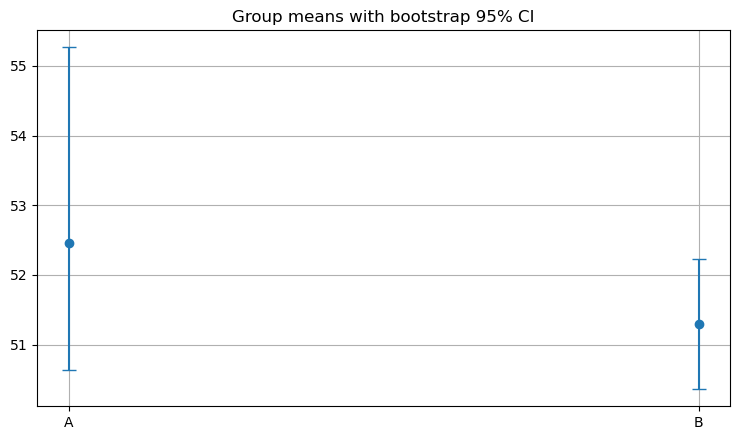

In [10]:
#Plots

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

out = Path("report"); out.mkdir(exist_ok=True)

def boot_ci_mean(x, iters=10000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    x = np.asarray(x); n = len(x)
    draws = [x[rng.integers(0, n, n)].mean() for _ in range(iters)]
    lo, hi = np.quantile(draws, [alpha/2, 1-alpha/2])
    return float(lo), float(hi)

# A and B must already be defined earlier (they are from your step 7)
meanA, meanB = A["revenue"].mean(), B["revenue"].mean()
loA, hiA = boot_ci_mean(A["revenue"].values, seed=42)
loB, hiB = boot_ci_mean(B["revenue"].values, seed=43)

xs    = np.arange(2)
means = np.array([meanA, meanB])
yerr  = np.vstack([means - np.array([loA, loB]),   # lower distances
                   np.array([hiA, hiB]) - means])  # upper distances

plt.figure()
plt.errorbar(xs, means, yerr=yerr, fmt='o', capsize=5)
plt.xticks(xs, ["A","B"])
plt.title("Group means with bootstrap 95% CI")
plt.tight_layout()
plt.savefig(out/"revenue_ci.png", dpi=170)



In [11]:
# --- Permutation test for mean(B) - mean(A) (2-sided) ---
import numpy as np

def perm_test_mean(a, b, iters=5000, seed=42):
    rng = np.random.default_rng(seed)
    a = np.asarray(a); b = np.asarray(b)
    obs = b.mean() - a.mean()
    pooled = np.concatenate([a, b]); n_b = len(b)
    cnt = 0
    for _ in range(iters):
        rng.shuffle(pooled)
        diff = pooled[-n_b:].mean() - pooled[:-n_b].mean()
        if abs(diff) >= abs(obs):
            cnt += 1
    return float(obs), float((cnt + 1) / (iters + 1))  # add-one smoothing

_, p_perm = perm_test_mean(A["revenue"].values, B["revenue"].values, iters=5000, seed=42)
print("Permutation p-value:", p_perm)


Permutation p-value: 0.46970605878824234


In [12]:
from pathlib import Path
import json

out = Path("report"); out.mkdir(exist_ok=True)

# --- pull values you already computed earlier ---
primary = {
    "metric": "retention_7",
    "meanA": float(res_prop["pA"]),
    "meanB": float(res_prop["pB"]),
    "delta": float(res_prop["delta"]),
    "ci_low": float(res_prop["ci_low"]),
    "ci_high": float(res_prop["ci_high"]),
    "pvalue": float(res_prop["pvalue"]),
}

secondary = {
    "metric": "sum_gamerounds",
    "meanA": float(res_mean["meanA"]),
    "meanB": float(res_mean["meanB"]),
    "delta": float(res_mean["delta"]),
    "ci_low_welch": float(res_mean["ci_low"]),
    "ci_high_welch": float(res_mean["ci_high"]),
    "boot_low": float(boot_lo),
    "boot_high": float(boot_hi),
    "p_perm": float(p_perm),      # from your permutation test cell
}

# --- save structured results ---
(out/"results.json").write_text(json.dumps({"primary": primary, "secondary": secondary}, indent=2))

# --- render a simple executive memo ---
memo_html = f"""
<h2>A/B Test – Game Experiment</h2>

<h3>Primary KPI: 7-day retention</h3>
<p>
A: {primary['meanA']:.4f} &nbsp;&nbsp; B: {primary['meanB']:.4f}<br>
Δ = {primary['delta']:.4f} (95% CI [{primary['ci_low']:.4f}, {primary['ci_high']:.4f}]),
p = {primary['pvalue']:.3f}
</p>

<h3>Secondary: Gameplay (sum_gamerounds)</h3>
<p>
A: {secondary['meanA']:.2f} &nbsp;&nbsp; B: {secondary['meanB']:.2f}<br>
Δ = {secondary['delta']:.2f}
(Welch 95% CI [{secondary['ci_low_welch']:.2f}, {secondary['ci_high_welch']:.2f}];
Bootstrap 95% CI [{secondary['boot_low']:.2f}, {secondary['boot_high']:.2f}];
Permutation p = {secondary['p_perm']:.3f})
</p>

<h3>Visuals</h3>
<p><img src="revenue_dist.png" width="520"></p>
<p><img src="revenue_ci.png"   width="520"></p>

<h3>Decision</h3>
<p>Base the ship/no-ship on the <b>primary KPI</b>. Secondary is supportive and not significant here.</p>
"""
(out/"memo.html").write_text(memo_html, encoding="utf-8")

print("Wrote:", out/"results.json", "and", out/"memo.html")


Wrote: report\results.json and report\memo.html
